## Classification modeling
---
- KMeans
- DBScan
- PCA
---
- Preprocessing: Standard scaler
- Transfer Learning: Pipeline - GridSearch - KFold
- Database: Postgre SQL

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import psycopg2 as pg2

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score

### Fetch data from database

In [151]:
def get_cur():
    db_pwd = 'password'
    conn = pg2.connect(database='AQI_2019', user='postgres', password=db_pwd)
    return conn.cursor()

def close():
    cur.close()
    conn.close()

cur = get_cur()

In [152]:
# fetch data
cur.execute("""SELECT * FROM aqi
            INNER JOIN measuring_pt ON measuring_pt.pt_id = aqi.pt_id
            """)
df = pd.DataFrame(cur.fetchall(), columns=['date', 'type', 'state', 'aqi', 'id1', 'lat', 'long', 'pt_id']).drop(columns=['id1'])

cur.execute("""SELECT measuring_pt.lat, measuring_pt.long, aqi.state FROM measuring_pt
            LEFT JOIN aqi ON measuring_pt.pt_id = aqi.pt_id
            GROUP BY measuring_pt.lat, measuring_pt.long, aqi.state
            """)
df_dist = pd.DataFrame(cur.fetchall(), columns=['lat', 'long', 'state'])

In [153]:
df.head(3)

,date,type,state,aqi,lat,long,pt_id
0,2019-01-01,PM25,Hawaii,24.0,19.117561,-155.778136,0
1,2019-01-02,PM25,Hawaii,20.0,19.117561,-155.778136,0
2,2019-01-03,PM25,Hawaii,21.0,19.117561,-155.778136,0


In [154]:
df_dist.shape

(1482, 3)

In [155]:
df_dist.head(2)

,lat,long,state
0,19.117561,-155.778136,Hawaii
1,19.203900,-155.480183,Hawaii


### Data preparation for modeling

In [156]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.DatetimeIndex(df['date']).month.map(str) + pd.DatetimeIndex(df['date']).day.map(str)
df['date'] = pd.to_datetime(df['date'], format='%m%d').dt.strftime('%m%d')

In [157]:
df['date'] = df['date'].map(lambda x: int(x))

In [158]:
df.head(3)

,date,type,state,aqi,lat,long,pt_id
0,101,PM25,Hawaii,24.0,19.117561,-155.778136,0
1,102,PM25,Hawaii,20.0,19.117561,-155.778136,0
2,103,PM25,Hawaii,21.0,19.117561,-155.778136,0


##### Standard scaler

In [159]:
ss = StandardScaler()

[ X: date, AQI, States / y: Air types - Ozone or PM 2.5 ]

In [160]:
X = df.drop(columns=['type', 'pt_id'])
y = df['type']

# We use get_dummies because it makes exogenous(X) readable
X = pd.get_dummies(X, columns=['state'], drop_first=True)
X.head(2)

,date,aqi,lat,long,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,101,24.0,19.117561,-155.778136,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,102,20.0,19.117561,-155.778136,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [162]:
ss.fit(X_train) # Always fit to X_train because of data leaking
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

[ X_sm: date, AQI, Air type / y_sm: 3 states(Texas, Washington, Illinois) ]

In [163]:
# Prepare data for Linear Regression
X_sm = df[(df['state'] == 'Texas') | (df['state'] == 'Washington') | (df['state'] == 'Illinois')].drop(columns=['state', 'pt_id', 'lat', 'long'])
y_sm = df[(df['state'] == 'Texas') | (df['state'] == 'Washington') | (df['state'] == 'Illinois')]['state']
X_sm = pd.get_dummies(X_sm, columns=['type'], drop_first=True)
X_sm.shape, y_sm.shape

((56677, 3), (56677,))

In [164]:
X_sm.head(2)

,date,aqi,type_PM25
5888,101,60.0,1
5889,102,44.0,1


In [165]:
X_sm_ss = ss.fit_transform(X_sm)

[ Xd: latitude, longitude / yd: state ]

In [166]:
Xd = df_dist.drop(columns='state')
yd = df_dist['state']

In [167]:
Xd.head(2)

,lat,long
0,19.117561,-155.778136
1,19.203900,-155.480183


In [168]:
Xd_ss = ss.fit_transform(Xd) # Always fit to X_train because of data leaking

### KMeans
Cluster based on latitude and longitude

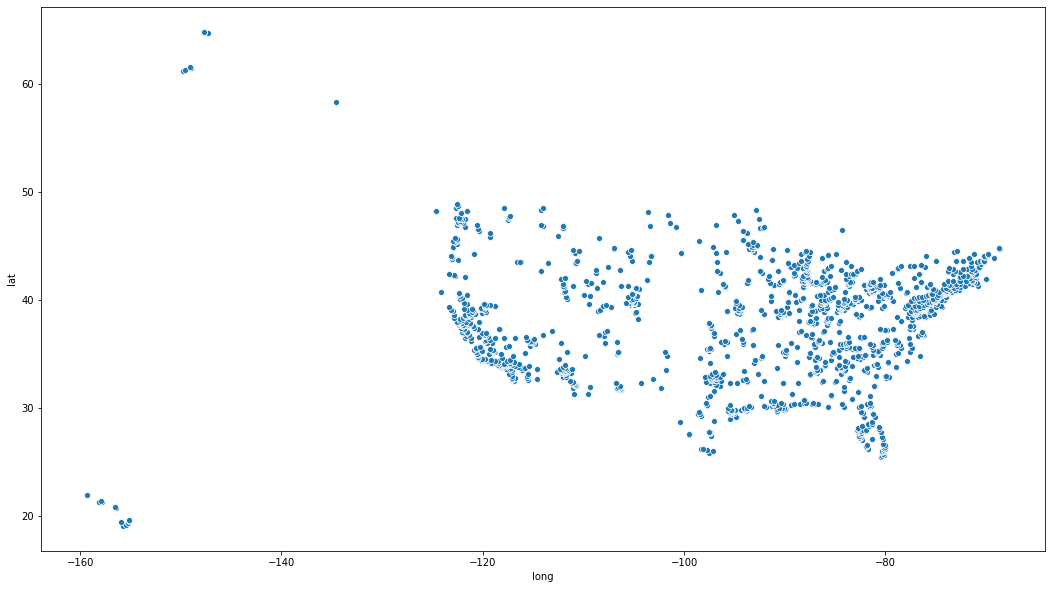

In [175]:
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x='long', y='lat', data=Xd)

In [176]:
km = KMeans(n_clusters=6, random_state=42)
km.fit(Xd_ss)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [177]:
df_km = Xd.copy()
df_km['state'] = yd
df_km['pred_state'] = km.predict(Xd_ss)

In [178]:
silhouette_score(Xd_ss, km.labels_)

0.5032310494620689

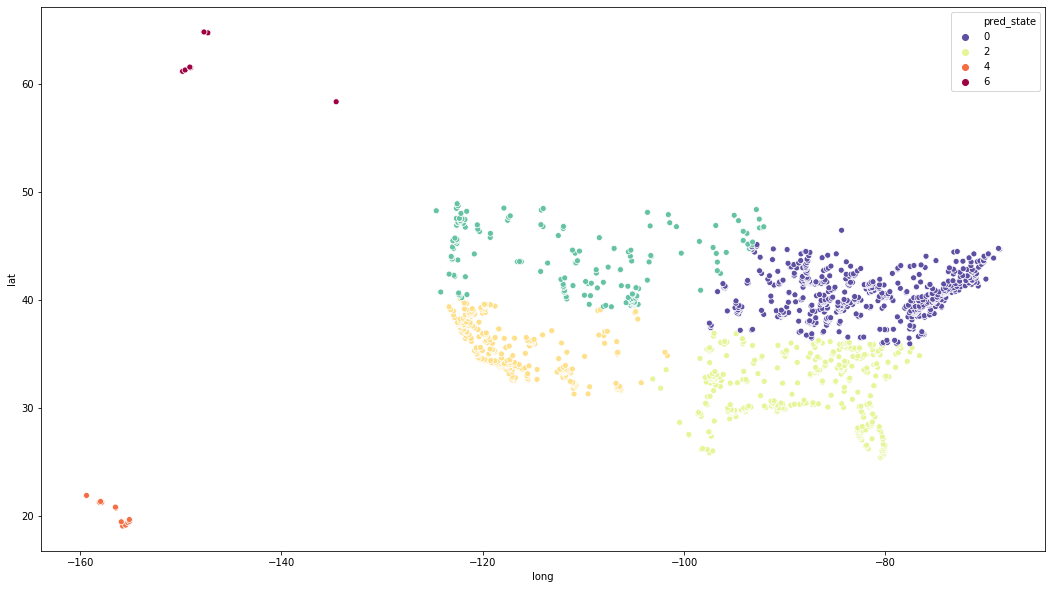

In [180]:
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x='long', y='lat', hue='pred_state', data=df_km, palette='Spectral_r')

### DBSCAN
Cluster based on latitude and longitude

In [181]:
dbscan = DBSCAN(eps=0.2)
dbscan.fit(Xd_ss)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [182]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [183]:
silhouette_score(Xd_ss, dbscan.labels_)

0.23268788154056616

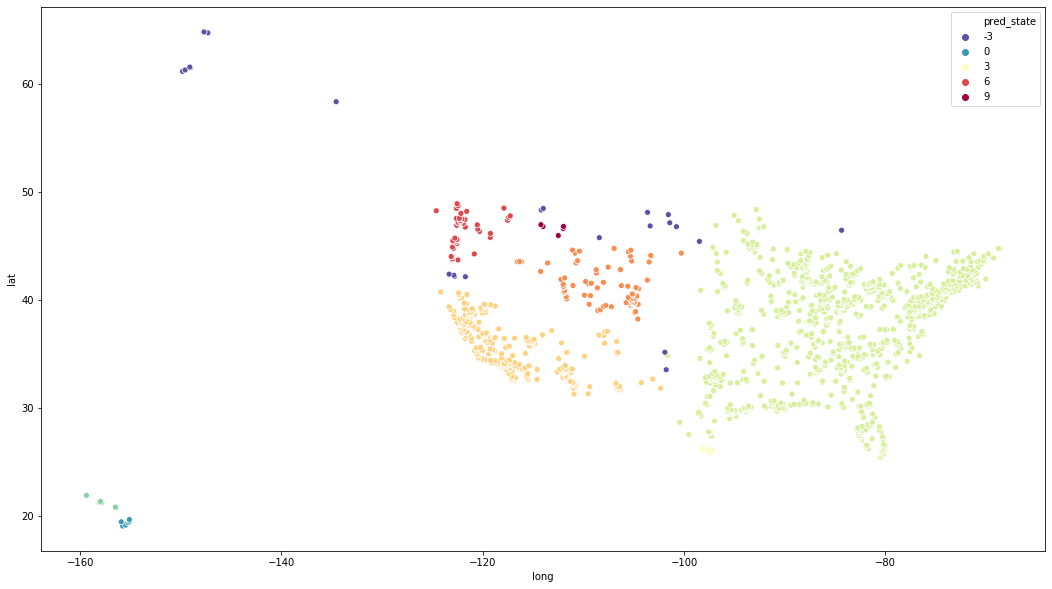

In [184]:
df_dbscan = Xd.copy()
df_dbscan['pred_state'] = dbscan.labels_

fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x='long', y='lat', hue='pred_state', data=df_dbscan, palette='Spectral_r')

### PCA
Predict air type based on AQI, state, date, lat & long

In [185]:
# Setting a baseline
lgr = LogisticRegression(solver='saga', random_state=42)
lgr.fit(X_train_ss, y_train)
lgr.score(X_train_ss, y_train), lgr.score(X_test_ss, y_test)

(0.7094902480623255, 0.7102056204866448)

Fit PCA

In [196]:
pca = PCA(whiten=True, random_state=42)
pca.fit(X_train_ss)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='full', tol=0.0, whiten=True)

In [197]:
pca_train = pca.transform(X_train_ss)
pca_test = pca.transform(X_test_ss)

lgr = LogisticRegression(solver='saga', random_state=42)
lgr.fit(pca_train, y_train)

lgr.score(pca_train, y_train), lgr.score(pca_test, y_test)

(0.7094588224538829, 0.7102346219657203)

#### Transfer learning
Result of Standard Scaler &rarr;  Result of PCA transform &rarr; Logistic regression

In [200]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('lgr', LogisticRegression())
])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    pipe,
    {
        'pca__whiten':[True, False],
        'lgr__solver':['saga', 'liblinear'],
        'lgr__C':[1.0, 30.0]
    }
)
gs.fit(X_train, y_train)

C:\Users\jjing\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lgr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False

In [201]:
gs.best_params_

{'lgr__C': 1.0, 'lgr__solver': 'liblinear', 'pca__whiten': False}

In [202]:
gs.best_score_

0.709298837538175

In [203]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.7094931049358203, 0.7101940198950146)